# Thermovision segmentation

## Data reading

In [1]:
import glob
import math
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

In [2]:
CLASSES = ["Person", "Car", "Bicycle", "OtherVechicle", "DontCare"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [3]:
def yolo2bbox(bboxes):
    """Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax."""
    xmin, ymin = bboxes[0] - bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0] + bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [4]:
def plot_box(
    image: np.ndarray,
    bboxes: list[list],
    labels: list[str],
    classes: list[str] = CLASSES,
    colors: list[int] = COLORS,
):
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    tf = max(lw - 1, 1)
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        xmin = int(x1 * width)
        ymin = int(y1 * height)
        xmax = int(x2 * width)
        ymax = int(y2 * height)
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]
        color = colors[classes.index(class_name)]
        cv2.rectangle(image, p1, p2, color=color, thickness=lw, lineType=cv2.LINE_AA)
        w, h = cv2.getTextSize(class_name, 0, fontScale=lw / 3, thickness=tf)[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(
            image, p1, p2, color=color, thickness=-1, lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw / 3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA,
        )
    return image

In [23]:
def plot_images(
    image_path: str,
    label_path: str,
    num_samples: int,
    classes: list[str] = CLASSES,
    colors: list[int] = COLORS,
):
    all_training_images = glob.glob(image_path + "/*")
    all_training_labels = glob.glob(label_path + "/*")
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(
        all_training_labels
    )

    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
    plt.figure(figsize=(5 * num_cols, 3 * num_rows))
    for i in range(num_samples):
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], "r") as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split()
                bboxes.append([float(x_c), float(y_c), float(w), float(h)])
                labels.append(label)
        plot_box(image, bboxes, labels, classes, colors)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image[:, :, ::-1])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

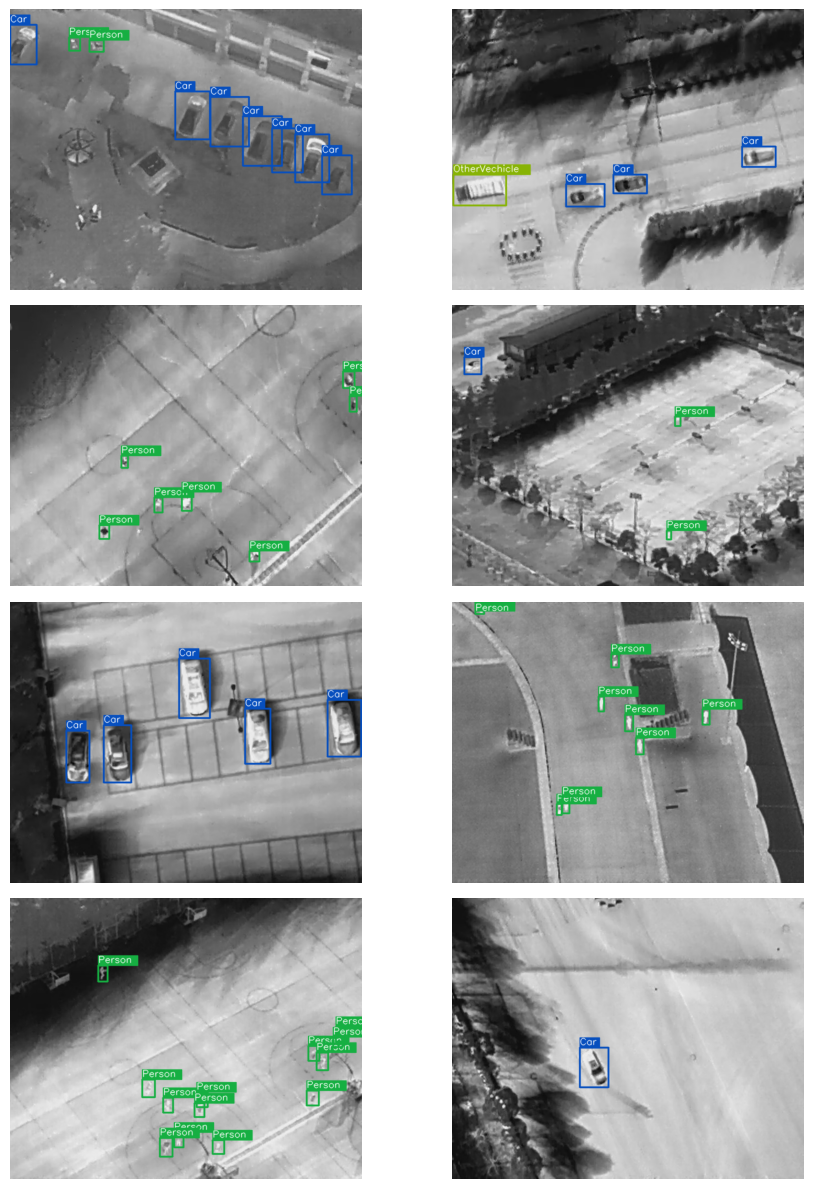

In [24]:
plot_images(
    image_path="data/images/train",
    label_path="data/labels/train",
    num_samples=8,
)

### EDA

In [7]:
# value distribution, img sizes?

## Training

In [8]:
model = YOLO("yolov8m.pt")

In [14]:
results = model.train(
    data="data/dataset.yaml", imgsz=512, epochs=50, batch=16, name="yolov8m_v8_50e"
)

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-1.11.0.post202 CUDA:0 (NVIDIA T500, 1871MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m_v8_50e9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

/home/zuzgaw/anaconda3/envs/geo-dl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/zuzgaw/anaconda3/envs/geo-dl/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.